[*********************100%***********************]  13 of 13 completed


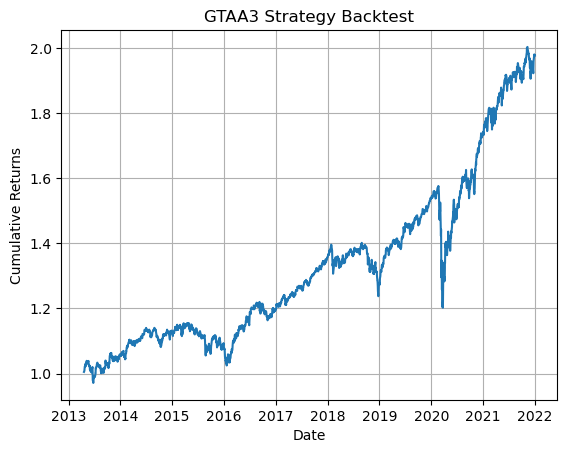

Initial Capital: $10000.00
Final Capital: $19775.60
Annualized Return (CAGR): 3.15%
Annualized Volatility: 9.94%
Best Month: 5.48%
Max Drawdown: -23.73%
Sharpe Ratio: 0.1160


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
    return data

def calculate_weights(data):
    # Calculate weights based on equal allocation
    num_assets = len(data.columns)
    weights = np.ones(num_assets) / num_assets
    return weights

def calculate_returns(data, weights):
    # Calculate portfolio returns
    portfolio_returns = data.pct_change().dot(weights)
    return portfolio_returns

def calculate_mdd(cumulative_returns):
    # Calculate the drawdowns
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak

    # Find the maximum drawdown
    max_drawdown = drawdown.min()

    return max_drawdown

def calculate_cagr(total_return, num_years):
    # Calculate Compound Annual Growth Rate (CAGR)
    cagr = (total_return ** (1 / num_years)) - 1

    return cagr

def backtest_gtaa3_strategy(tickers, start_date, end_date, initial_capital):
    # Get data
    data = get_data(tickers, start_date, end_date)

    # Calculate weights
    weights = calculate_weights(data)

    # Calculate returns
    portfolio_returns = calculate_returns(data, weights)

    # Calculate cumulative returns
    cumulative_returns = (portfolio_returns + 1).cumprod()

    # Calculate annualized returns
    total_return = cumulative_returns[-1]
    num_years = len(data) / 252  # Assume 252 trading days in a year
    annualized_return = calculate_cagr(total_return, num_years)

    # Calculate annualized volatility
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)

    # Calculate maximum drawdown
    max_drawdown = calculate_mdd(cumulative_returns)

    # Perform rebalancing every month
    monthly_rebalance_dates = pd.date_range(start=start_date, end=end_date, freq='M')
    for date in monthly_rebalance_dates:
        # Calculate momentum for each asset
        asset_momentum = data.loc[:date].pct_change(252).iloc[-1]

        # Calculate 10-month moving average
        ma_10 = data.loc[:date].rolling(window=10).mean().iloc[-1]

        # Select assets with positive momentum and above their 10-month moving average
        selected_assets = asset_momentum[asset_momentum > 0][asset_momentum > ma_10]

        # Sort assets by momentum and select the top 3
        top_assets = selected_assets.nlargest(3)

        # Update weights for selected assets
        weights = np.zeros(len(data.columns))
        weights[top_assets.index.to_list()] = 1 / 3

        # Calculate returns for the remaining period
        portfolio_returns.loc[date:] = calculate_returns(data.loc[date:], weights)

    # Plot cumulative returns
    plt.plot(cumulative_returns)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title('GTAA3 Strategy Backtest')
    plt.grid(True)
    plt.show()

    # Print performance metrics
    final_capital = initial_capital * cumulative_returns[-1]
    best_month = cumulative_returns.pct_change().max()
    mdd = max_drawdown
    returns_month = portfolio_returns.resample('M').sum()
    sharpe_ratio = (annualized_return - 0.02) / annualized_volatility

    print("Initial Capital: ${:.2f}".format(initial_capital))
    print("Final Capital: ${:.2f}".format(final_capital))
    print("Annualized Return (CAGR): {:.2%}".format(annualized_return))
    print("Annualized Volatility: {:.2%}".format(annualized_volatility))
    print("Best Month: {:.2%}".format(best_month))
    print("Max Drawdown: {:.2%}".format(mdd))
    print("Sharpe Ratio: {:.4f}".format(sharpe_ratio))

# Define the tickers and the date range
tickers = ["SPY", "IWD", "IWM", "IWN", "MTUM", "EFA", "TLT", "IEF", "LQD", "DBC", "VNQ", "BWX", "GLD"]
start_date = "2000-01-01"
end_date = "2022-01-01"
initial_capital = 10000

# Run the backtest
backtest_gtaa3_strategy(tickers, start_date, end_date, initial_capital)
